MF를 이용한 간단한 변수 추출

In [1]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 간단한 데이터 전처리

In [2]:
class MakeDataset():

    def __init__(self, DATA_PATH):
        
        dtype = {
            'userID': 'int16',
            'answerCode': 'int8',
            'KnowledgeTag': 'int16'
        }
        
        train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
        train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

        test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
        test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

        def get_paper_number(x):
            return x[1:-3]

        def get_paper_question_number(x):
            return x[-3:]

        def get_large_paper_number(x):
            return x[1:4]
        
        train_df['paper_number'] = train_df['assessmentItemID'].apply(lambda x : get_paper_number(x))
        train_df['paper_question_number'] = train_df['assessmentItemID'].apply(lambda x : get_paper_question_number(x))
        train_df['large_paper_number'] = train_df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))

        test_df['paper_number'] = test_df['assessmentItemID'].apply(lambda x : get_paper_number(x))
        test_df['paper_question_number'] = test_df['assessmentItemID'].apply(lambda x : get_paper_question_number(x))
        test_df['large_paper_number'] = test_df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))

        # 문제 푸는데 걸린 시간
        def get_elapsed(df):
            
            diff = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
            diff = diff.fillna(pd.Timedelta(seconds=0))
            diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
            df['elapsed'] = diff
            df['elapsed'] = df['elapsed'].apply(lambda x : x if x < 650 and x >=0 else 0)
            df['elapsed'] = df['elapsed'] / 650

            return df

        train_df = get_elapsed(df = train_df)
        test_df = get_elapsed(df = test_df)

        all_df = pd.concat([train_df, test_df])
        all_df = all_df[all_df['answerCode'] != -1].reset_index(drop = True)

        # 문항별 정답률
        train_df = train_df.set_index('assessmentItemID')
        train_df['assessmentItemID_mean_answerCode'] = all_df.groupby('assessmentItemID').mean()['answerCode']
        train_df = train_df.reset_index(drop = False)

        test_df = test_df.set_index('assessmentItemID')
        test_df['assessmentItemID_mean_answerCode'] = all_df.groupby('assessmentItemID').mean()['answerCode']
        test_df = test_df.reset_index(drop = False)

        # 시험지별 정답률
        train_df = train_df.set_index('testId')
        train_df['testId_mean_answerCode'] = all_df.groupby('testId').mean()['answerCode']
        train_df = train_df.reset_index(drop = False)

        test_df = test_df.set_index('testId')
        test_df['testId_mean_answerCode'] = all_df.groupby('testId').mean()['answerCode']
        test_df = test_df.reset_index(drop = False)

        # 태그별 정답률 
        train_df = train_df.set_index('KnowledgeTag')
        train_df['KnowledgeTag_mean_answerCode'] = all_df.groupby('KnowledgeTag').mean()['answerCode']
        train_df = train_df.reset_index(drop = False)

        test_df = test_df.set_index('KnowledgeTag')
        test_df['KnowledgeTag_mean_answerCode'] = all_df.groupby('KnowledgeTag').mean()['answerCode']
        test_df = test_df.reset_index(drop = False)

        # 문제 푼 시간
        train_df['hour'] = train_df['Timestamp'].dt.hour / 23
        test_df['hour'] = test_df['Timestamp'].dt.hour / 23

        # 문제 푼 요일
        train_df['dayofweek'] = train_df['Timestamp'].dt.dayofweek / 6
        test_df['dayofweek'] = test_df['Timestamp'].dt.dayofweek / 6

        total_user_list = train_df['userID'].unique().tolist()
        random.seed(22)
        val_user_list = random.sample(total_user_list, test_df['userID'].nunique())

        train = []
        valid = []
        test = []

        group_df = train_df.groupby('userID')

        for userID, df in group_df:
            if userID in val_user_list:
                trn_df = df.iloc[:-1, :]
                val_df = df.iloc[-1:, :]

                train.append(trn_df)
                valid.append(val_df)
            else:
                train.append(df)

        group_df = test_df.groupby('userID')

        for userID, df in group_df:
            trn_df = df.iloc[:-1, :]
            te_df = df.iloc[-1:, :]

            train.append(trn_df)
            test.append(te_df)

        train = pd.concat(train)
        valid = pd.concat(valid)
        test = pd.concat(test)

        def get_val2idx(val_list : list) -> dict:
            val2idx = {}
            for idx, val in enumerate(val_list):
                val2idx[val] = idx
            
            return val2idx

        all_df = pd.concat([train, valid, test])

        assessmentItemID2idx = get_val2idx(all_df['assessmentItemID'].unique().tolist())
        testId2idx = get_val2idx(all_df['testId'].unique().tolist())
        KnowledgeTag2idx = get_val2idx(all_df['KnowledgeTag'].unique().tolist())
        large_paper_number2idx = get_val2idx(all_df['large_paper_number'].unique().tolist())

        train['assessmentItemID2idx'] = train['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
        train['testId2idx'] = train['testId'].apply(lambda x : testId2idx[x])
        train['KnowledgeTag2idx'] = train['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
        train['large_paper_number2idx'] = train['large_paper_number'].apply(lambda x : large_paper_number2idx[x])

        valid['assessmentItemID2idx'] = valid['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
        valid['testId2idx'] = valid['testId'].apply(lambda x : testId2idx[x])
        valid['KnowledgeTag2idx'] = valid['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
        valid['large_paper_number2idx'] = valid['large_paper_number'].apply(lambda x : large_paper_number2idx[x])

        test['assessmentItemID2idx'] = test['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
        test['testId2idx'] = test['testId'].apply(lambda x : testId2idx[x])
        test['KnowledgeTag2idx'] = test['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
        test['large_paper_number2idx'] = test['large_paper_number'].apply(lambda x : large_paper_number2idx[x])

        self.train, self.valid, self.test = train, valid, test
        self.num_userID = train['userID'].nunique()
        self.num_assessmentItemID = len(assessmentItemID2idx)
        self.num_testId = len(testId2idx)
        self.num_KnowledgeTag = len(KnowledgeTag2idx)
        self.num_large_paper_number = len(large_paper_number2idx)
    
    def get_data(self):
        return self.train, self.valid, self.test

In [3]:
class CustomDataset(Dataset):
    def __init__(self, df, test = False):
        cat_cols = ['userID', 'assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'large_paper_number2idx']
        num_cols = ['elapsed', 'assessmentItemID_mean_answerCode', 'testId_mean_answerCode', 'KnowledgeTag_mean_answerCode', 'hour', 'dayofweek']
        self.cat_feature = df[cat_cols].values
        self.num_feature = df[num_cols].values
        self.test = test
        if not self.test:
            self.answerCode = df['answerCode'].astype(float).tolist()

    def __len__(self):
        return len(self.cat_feature)

    def __getitem__(self, idx):
        cat_feature = self.cat_feature[idx, :]
        num_feature = self.num_feature[idx, :]
        if not self.test:
            answerCode = self.answerCode[idx]
            return {'cat_feature' : cat_feature, 'num_feature' : num_feature, 'answerCode' : answerCode}
        return {'cat_feature' : cat_feature, 'num_feature' : num_feature}

# 간단한 모델

In [4]:
class MF(nn.Module):
    def __init__(self, num_userID, num_assessmentItemID, num_testId, num_KnowledgeTag, num_large_paper_number, num_factor = 50, hidden_size = 256, num_layers = 3, dropout_rate = 0.5):
        super(MF, self).__init__()
        self.userID_emb = nn.Embedding(num_userID, num_factor)
        self.assessmentItemID_emb = nn.Embedding(num_assessmentItemID, num_factor)
        self.testId_emb = nn.Embedding(num_testId, num_factor)
        self.KnowledgeTag_emb = nn.Embedding(num_KnowledgeTag, num_factor)
        self.large_paper_number_emb = nn.Embedding(num_large_paper_number, num_factor)
        self.hour_emb = nn.Embedding(24, num_factor)
        self.dayofweek_emb = nn.Embedding(7, num_factor)

        self.cat_emb = nn.Sequential(
            nn.Linear(7 * num_factor, hidden_size // 2, bias = False),
            nn.BatchNorm1d(hidden_size // 2),
        )

        self.num_emb = nn.Sequential(
            nn.Linear(4, hidden_size // 2, bias = False),
            nn.BatchNorm1d(hidden_size // 2),
        )

        self.cat_cols = ['userID', 'assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'large_paper_number2idx', 'hour', 'dayofweek']

        MLP_modules = []
        for i in range(num_layers):
            if i == 0:
                MLP_modules.append(nn.Dropout(p = dropout_rate))
                MLP_modules.append(nn.Linear(hidden_size, hidden_size))
                MLP_modules.append(nn.BatchNorm1d(hidden_size))
                MLP_modules.append(nn.ReLU())
            else:
                MLP_modules.append(nn.Dropout(p = dropout_rate))
                MLP_modules.append(nn.Linear(hidden_size, hidden_size // 2))
                MLP_modules.append(nn.BatchNorm1d(hidden_size // 2))
                MLP_modules.append(nn.ReLU())
                hidden_size = hidden_size // 2

        self.MLP_layers = nn.Sequential(*MLP_modules)

        self.predict_layer = nn.Sequential(
            nn.Linear(hidden_size, 1, bias = False),
            nn.Sigmoid()
        )
        self._init_weight_()

    def _init_weight_(self):
        self.userID_emb.weight.data.normal_(0, 1.0 / self.userID_emb.embedding_dim)
        self.assessmentItemID_emb.weight.data.normal_(0, 1.0 / self.assessmentItemID_emb.embedding_dim)
        self.testId_emb.weight.data.normal_(0, 1.0 / self.testId_emb.embedding_dim)
        self.KnowledgeTag_emb.weight.data.normal_(0, 1.0 / self.KnowledgeTag_emb.embedding_dim)
        self.large_paper_number_emb.weight.data.normal_(0, 1.0 / self.large_paper_number_emb.embedding_dim)
        self.hour_emb.weight.data.normal_(0, 1.0 / self.hour_emb.embedding_dim)
        self.dayofweek_emb.weight.data.normal_(0, 1.0 / self.dayofweek_emb.embedding_dim)
        
        for m in self.cat_emb:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        for m in self.num_emb:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        for m in self.MLP_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1)
    
    def forward(self, cat_feature, num_feature):
        
        cat_emb_list = []
        for idx in range(len(self.cat_cols)):
            if self.cat_cols[idx] == 'userID':
                cat_emb_list.append(self.userID_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'assessmentItemID2idx':
                cat_emb_list.append(self.assessmentItemID_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'testId2idx':
                cat_emb_list.append(self.testId_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'KnowledgeTag2idx':
                cat_emb_list.append(self.KnowledgeTag_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'large_paper_number2idx':
                cat_emb_list.append(self.large_paper_number_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'hour':
                cat_emb_list.append(self.hour_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'dayofweek':
                cat_emb_list.append(self.dayofweek_emb(cat_feature[:, idx]))
        
        cat_emb = torch.concat(cat_emb_list, dim = 1)
        cat_emb = self.cat_emb(cat_emb)
        num_emb = self.num_emb(num_feature)

        emb = torch.concat([cat_emb, num_emb], dim = 1)

        output = self.MLP_layers(emb)
        output = self.predict_layer(output)

        return output.view(-1)

In [5]:
class MF(nn.Module):
    def __init__(self, num_userID, num_assessmentItemID, num_testId, num_KnowledgeTag, num_large_paper_number, num_factor = 50, hidden_size = 256, num_layers = 3, dropout_rate = 0.5):
        super(MF, self).__init__()
        self.userID_emb = nn.Embedding(num_userID, num_factor)
        self.assessmentItemID_emb = nn.Embedding(num_assessmentItemID, num_factor)
        self.testId_emb = nn.Embedding(num_testId, num_factor)
        self.KnowledgeTag_emb = nn.Embedding(num_KnowledgeTag, num_factor)
        self.large_paper_number_emb = nn.Embedding(num_large_paper_number, num_factor)

        self.cat_emb = nn.Linear(5 * num_factor, hidden_size // 2, bias = False)

        self.num_emb = nn.Linear(6, hidden_size // 2, bias = False)

        self.cat_cols = ['userID', 'assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'large_paper_number2idx']

        MLP_modules = []
        for i in range(num_layers):
            if i == 0:
                MLP_modules.append(nn.BatchNorm1d(hidden_size))
                MLP_modules.append(nn.Dropout(p = dropout_rate))
                MLP_modules.append(nn.Linear(hidden_size, hidden_size))
                MLP_modules.append(nn.ReLU())
            else:
                MLP_modules.append(nn.Dropout(p = dropout_rate))
                MLP_modules.append(nn.Linear(hidden_size, hidden_size // 2))
                MLP_modules.append(nn.ReLU())
                hidden_size = hidden_size // 2

        self.MLP_layers = nn.Sequential(*MLP_modules)

        self.predict_layer = nn.Sequential(
            nn.Linear(hidden_size, 1, bias = False),
            nn.Sigmoid()
        )
        self._init_weight_()

    def _init_weight_(self):
        self.userID_emb.weight.data.normal_(0, 1.0 / self.userID_emb.embedding_dim)
        self.assessmentItemID_emb.weight.data.normal_(0, 1.0 / self.assessmentItemID_emb.embedding_dim)
        self.testId_emb.weight.data.normal_(0, 1.0 / self.testId_emb.embedding_dim)
        self.KnowledgeTag_emb.weight.data.normal_(0, 1.0 / self.KnowledgeTag_emb.embedding_dim)
        self.large_paper_number_emb.weight.data.normal_(0, 1.0 / self.large_paper_number_emb.embedding_dim)
        # self.hour_emb.weight.data.normal_(0, 1.0 / self.hour_emb.embedding_dim)
        # self.dayofweek_emb.weight.data.normal_(0, 1.0 / self.dayofweek_emb.embedding_dim)

        # nn.init.xavier_uniform_(self.cat_emb.weight)
        
        # for m in self.num_emb:
        #     if isinstance(m, nn.Linear):
        #         nn.init.xavier_uniform_(m.weight)

        for m in self.MLP_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1)
    
    def forward(self, cat_feature, num_feature):
        
        cat_emb_list = []
        for idx in range(len(self.cat_cols)):
            if self.cat_cols[idx] == 'userID':
                cat_emb_list.append(self.userID_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'assessmentItemID2idx':
                cat_emb_list.append(self.assessmentItemID_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'testId2idx':
                cat_emb_list.append(self.testId_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'KnowledgeTag2idx':
                cat_emb_list.append(self.KnowledgeTag_emb(cat_feature[:, idx]))
            elif self.cat_cols[idx] == 'large_paper_number2idx':
                cat_emb_list.append(self.large_paper_number_emb(cat_feature[:, idx]))
        
        cat_emb = torch.concat(cat_emb_list, dim = 1)
        cat_emb = self.cat_emb(cat_emb)
        num_emb = self.num_emb(num_feature)

        emb = torch.concat([cat_emb, num_emb], dim = 1)

        output = self.MLP_layers(emb)
        output = self.predict_layer(output)

        return output.view(-1)

In [6]:
from sklearn.metrics import roc_auc_score

def train(model, data_loader, criterion, optimizer):
    model.train()
    loss_val = 0

    for cat_feature, num_feature, answerCode in data_loader:
        cat_feature, num_feature, answerCode = cat_feature.to(device), num_feature.to(device), answerCode.to(device)

        optimizer.zero_grad()

        output = model(cat_feature, num_feature)
        loss = criterion(output, answerCode)

        loss.backward()
        optimizer.step()

        loss_val += loss.item()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader):
    model.eval()

    target = []
    pred = []

    with torch.no_grad():
        for cat_feature, num_feature, answerCode in data_loader:
            cat_feature, num_feature = cat_feature.to(device), num_feature.to(device)
            output = model(cat_feature, num_feature)

            target.extend(answerCode.cpu().numpy().tolist())
            pred.extend(output.cpu().numpy().tolist())

    roc_auc = roc_auc_score(target, pred)

    return roc_auc


def predict(model, data_loader):
    model.eval()

    pred = []

    with torch.no_grad():
        for cat_feature, num_feature in data_loader:
            cat_feature, num_feature = cat_feature.to(device), num_feature.to(device)
            
            output = model(cat_feature, num_feature)

            pred.extend(output.cpu().numpy().tolist())

    return pred

# 학습

In [7]:
batch_size = 5000
epochs = 20
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_PATH = '/opt/ml/input/data'
MODEL_PATH = '/opt/ml/model'
SUBMISSION_PATH = '/opt/ml/submission'

model_name = 'MF-num-faeture.pt'
submission_name = 'MF-num-faeture.csv'

In [8]:
if not os.path.isdir(MODEL_PATH):
    os.mkdir(MODEL_PATH)

In [9]:
if not os.path.isdir(SUBMISSION_PATH):
    os.mkdir(SUBMISSION_PATH)

In [10]:
make_dataset = MakeDataset(DATA_PATH = DATA_PATH)
train_df, valid_df, test_df = make_dataset.get_data()

In [11]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed_everything(22)

In [12]:
def train_make_batch(samples):
    cat_feature = [sample['cat_feature'] for sample in samples]
    num_feature = [sample['num_feature'] for sample in samples]
    answerCode = [sample['answerCode'] for sample in samples]
    return torch.tensor(cat_feature), torch.tensor(num_feature, dtype = torch.float32), torch.tensor(answerCode, dtype = torch.float32)

def test_make_batch(samples):
    cat_feature = [sample['cat_feature'] for sample in samples]
    num_feature = [sample['num_feature'] for sample in samples]
    return torch.tensor(cat_feature), torch.tensor(num_feature, dtype = torch.float32)

train_dataset = CustomDataset(df = train_df)
train_data_loader = DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
    drop_last = False,
    collate_fn = train_make_batch)

valid_dataset = CustomDataset(df = valid_df)
valid_data_loader = DataLoader(
    valid_dataset, 
    batch_size = batch_size, 
    shuffle = False, 
    drop_last = False,
    collate_fn = train_make_batch)


test_dataset = CustomDataset(df = test_df, test = True)
test_data_loader = DataLoader(
    test_dataset, 
    batch_size = batch_size, 
    shuffle = False, 
    drop_last = False,
    collate_fn = test_make_batch)

In [13]:
model = MF(
    num_userID = make_dataset.num_userID, 
    num_assessmentItemID = make_dataset.num_assessmentItemID, 
    num_testId = make_dataset.num_testId, 
    num_KnowledgeTag = make_dataset.num_KnowledgeTag, 
    num_large_paper_number = make_dataset.num_large_paper_number,).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()

In [14]:
best_roc_auc = 0
for epoch in range(1, epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(model = model, data_loader = train_data_loader, criterion = criterion, optimizer = optimizer)
        roc_auc = evaluate(model = model, data_loader = valid_data_loader)
        if best_roc_auc < roc_auc:
            best_roc_auc = roc_auc
            torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name))

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| roc_auc: {roc_auc:.5f}')

Epoch:   1| Train loss: 0.52825| roc_auc: 0.77540: 100%|██████████| 1/1 [00:22<00:00, 22.85s/it]
Epoch:   2| Train loss: 0.49142| roc_auc: 0.79555: 100%|██████████| 1/1 [00:23<00:00, 23.18s/it]
Epoch:   3| Train loss: 0.47675| roc_auc: 0.79656: 100%|██████████| 1/1 [00:22<00:00, 22.50s/it]
Epoch:   4| Train loss: 0.46809| roc_auc: 0.80408: 100%|██████████| 1/1 [00:23<00:00, 23.08s/it]
Epoch:   5| Train loss: 0.46213| roc_auc: 0.80581: 100%|██████████| 1/1 [00:23<00:00, 23.49s/it]
Epoch:   6| Train loss: 0.45740| roc_auc: 0.80334: 100%|██████████| 1/1 [00:22<00:00, 22.97s/it]
Epoch:   7| Train loss: 0.45379| roc_auc: 0.80774: 100%|██████████| 1/1 [00:22<00:00, 22.88s/it]
Epoch:   8| Train loss: 0.45088| roc_auc: 0.79965: 100%|██████████| 1/1 [00:22<00:00, 22.76s/it]
Epoch:   9| Train loss: 0.44852| roc_auc: 0.80050: 100%|██████████| 1/1 [00:22<00:00, 22.79s/it]
Epoch:  10| Train loss: 0.44621| roc_auc: 0.79826: 100%|██████████| 1/1 [00:23<00:00, 23.15s/it]
Epoch:  11| Train loss: 0.4444

```
요일 시간 임베딩 O

Epoch:   1| Train loss: 0.52273| roc_auc: 0.77906: 100%|██████████| 1/1 [00:23<00:00, 23.62s/it]
Epoch:   2| Train loss: 0.48620| roc_auc: 0.79568: 100%|██████████| 1/1 [00:23<00:00, 23.76s/it]
Epoch:   3| Train loss: 0.47378| roc_auc: 0.80276: 100%|██████████| 1/1 [00:23<00:00, 23.44s/it]
Epoch:   4| Train loss: 0.46635| roc_auc: 0.80135: 100%|██████████| 1/1 [00:22<00:00, 22.99s/it]
Epoch:   5| Train loss: 0.46074| roc_auc: 0.80325: 100%|██████████| 1/1 [00:23<00:00, 23.64s/it]
Epoch:   6| Train loss: 0.45605| roc_auc: 0.80457: 100%|██████████| 1/1 [00:24<00:00, 24.24s/it]
Epoch:   7| Train loss: 0.45265| roc_auc: 0.79978: 100%|██████████| 1/1 [00:23<00:00, 23.70s/it]
Epoch:   8| Train loss: 0.44937| roc_auc: 0.80077: 100%|██████████| 1/1 [00:23<00:00, 23.56s/it]
Epoch:   9| Train loss: 0.44691| roc_auc: 0.80653: 100%|██████████| 1/1 [00:23<00:00, 23.26s/it]
Epoch:  10| Train loss: 0.44475| roc_auc: 0.80633: 100%|██████████| 1/1 [00:23<00:00, 23.46s/it]
Epoch:  11| Train loss: 0.44253| roc_auc: 0.80382: 100%|██████████| 1/1 [00:23<00:00, 23.63s/it]
Epoch:  12| Train loss: 0.44065| roc_auc: 0.80222: 100%|██████████| 1/1 [00:23<00:00, 23.41s/it]
Epoch:  13| Train loss: 0.43892| roc_auc: 0.79892: 100%|██████████| 1/1 [00:23<00:00, 23.78s/it]
Epoch:  14| Train loss: 0.43741| roc_auc: 0.80521: 100%|██████████| 1/1 [00:23<00:00, 23.00s/it]
Epoch:  15| Train loss: 0.43596| roc_auc: 0.80274: 100%|██████████| 1/1 [00:23<00:00, 23.11s/it]
Epoch:  16| Train loss: 0.43507| roc_auc: 0.80751: 100%|██████████| 1/1 [00:23<00:00, 23.57s/it]
Epoch:  17| Train loss: 0.43379| roc_auc: 0.80192: 100%|██████████| 1/1 [00:23<00:00, 23.62s/it]
Epoch:  18| Train loss: 0.43282| roc_auc: 0.79844: 100%|██████████| 1/1 [00:23<00:00, 23.36s/it]
Epoch:  19| Train loss: 0.43171| roc_auc: 0.79855: 100%|██████████| 1/1 [00:23<00:00, 23.55s/it]
Epoch:  20| Train loss: 0.43081| roc_auc: 0.80475: 100%|██████████| 1/1 [00:23<00:00, 23.50s/it]

```

```
요일 시간 임베딩 X
Epoch:   1| Train loss: 0.52825| roc_auc: 0.77540: 100%|██████████| 1/1 [00:22<00:00, 22.85s/it]
Epoch:   2| Train loss: 0.49142| roc_auc: 0.79555: 100%|██████████| 1/1 [00:23<00:00, 23.18s/it]
Epoch:   3| Train loss: 0.47675| roc_auc: 0.79656: 100%|██████████| 1/1 [00:22<00:00, 22.50s/it]
Epoch:   4| Train loss: 0.46809| roc_auc: 0.80408: 100%|██████████| 1/1 [00:23<00:00, 23.08s/it]
Epoch:   5| Train loss: 0.46213| roc_auc: 0.80581: 100%|██████████| 1/1 [00:23<00:00, 23.49s/it]
Epoch:   6| Train loss: 0.45740| roc_auc: 0.80334: 100%|██████████| 1/1 [00:22<00:00, 22.97s/it]
Epoch:   7| Train loss: 0.45379| roc_auc: 0.80774: 100%|██████████| 1/1 [00:22<00:00, 22.88s/it]
Epoch:   8| Train loss: 0.45088| roc_auc: 0.79965: 100%|██████████| 1/1 [00:22<00:00, 22.76s/it]
Epoch:   9| Train loss: 0.44852| roc_auc: 0.80050: 100%|██████████| 1/1 [00:22<00:00, 22.79s/it]
Epoch:  10| Train loss: 0.44621| roc_auc: 0.79826: 100%|██████████| 1/1 [00:23<00:00, 23.15s/it]
Epoch:  11| Train loss: 0.44445| roc_auc: 0.80144: 100%|██████████| 1/1 [00:23<00:00, 23.21s/it]
Epoch:  12| Train loss: 0.44257| roc_auc: 0.79824: 100%|██████████| 1/1 [00:23<00:00, 23.60s/it]
Epoch:  13| Train loss: 0.44116| roc_auc: 0.79555: 100%|██████████| 1/1 [00:22<00:00, 22.55s/it]
Epoch:  14| Train loss: 0.43945| roc_auc: 0.79972: 100%|██████████| 1/1 [00:22<00:00, 22.98s/it]
Epoch:  15| Train loss: 0.43827| roc_auc: 0.80069: 100%|██████████| 1/1 [00:23<00:00, 23.16s/it]
Epoch:  16| Train loss: 0.43737| roc_auc: 0.80120: 100%|██████████| 1/1 [00:22<00:00, 22.27s/it]
Epoch:  17| Train loss: 0.43620| roc_auc: 0.80275: 100%|██████████| 1/1 [00:22<00:00, 22.44s/it]
Epoch:  18| Train loss: 0.43506| roc_auc: 0.79362: 100%|██████████| 1/1 [00:23<00:00, 23.14s/it]
Epoch:  19| Train loss: 0.43397| roc_auc: 0.79988: 100%|██████████| 1/1 [00:22<00:00, 22.96s/it]
Epoch:  20| Train loss: 0.43281| roc_auc: 0.79809: 100%|██████████| 1/1 [00:23<00:00, 23.31s/it]

```

In [14]:
model = MF(
    num_userID = make_dataset.num_userID, 
    num_assessmentItemID = make_dataset.num_assessmentItemID, 
    num_testId = make_dataset.num_testId, 
    num_KnowledgeTag = make_dataset.num_KnowledgeTag, 
    num_large_paper_number = make_dataset.num_large_paper_number,).to(device)

model.load_state_dict(torch.load(os.path.join(MODEL_PATH, model_name)))
pred_list = predict(model = model, data_loader = test_data_loader)

In [15]:
submission = pd.DataFrame(data = np.array(pred_list), columns = ['prediction'])
submission['id'] = submission.index
submission = submission[['id', 'prediction']]
submission.to_csv(os.path.join(SUBMISSION_PATH, submission_name), index = False)

# 시각화

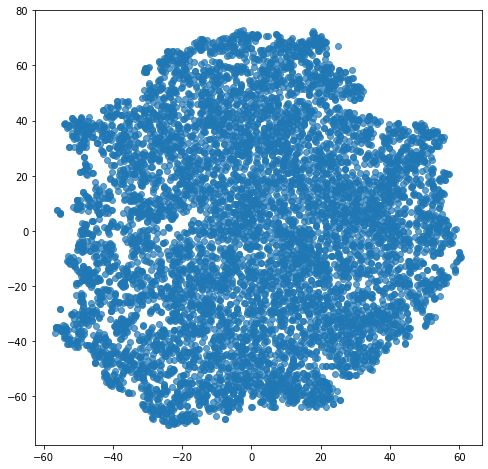

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

arr = model.userID_emb.weight.data.cpu().numpy()

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()

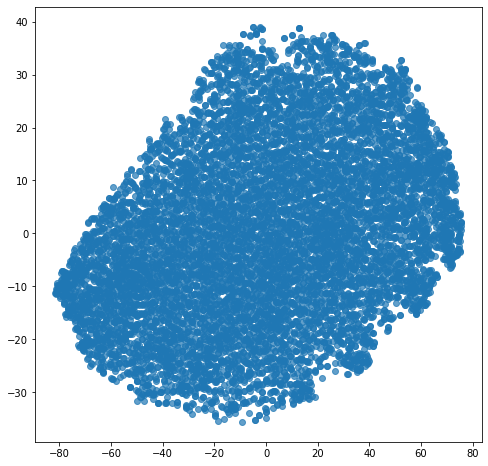

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

arr = model.assessmentItemID_emb.weight.data.cpu().numpy()

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()

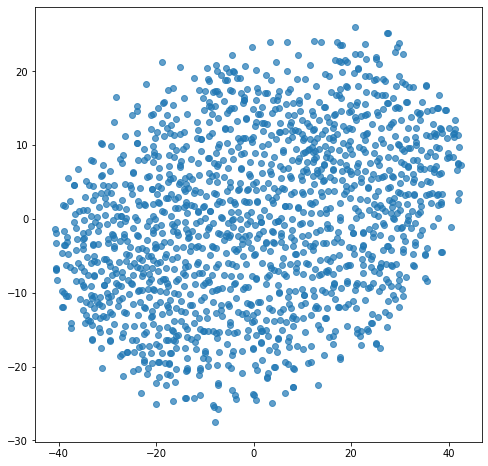

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

arr = model.testId_emb.weight.data.cpu().numpy()

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()

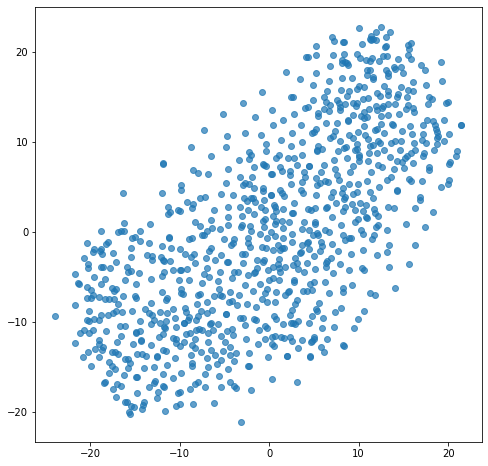

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

arr = model.KnowledgeTag_emb.weight.data.cpu().numpy()

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()

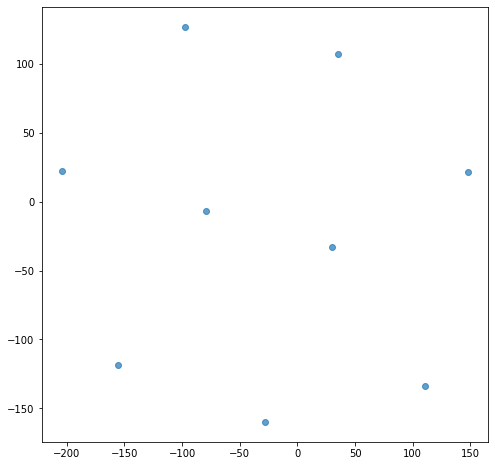

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

arr = model.large_paper_number_emb.weight.data.cpu().numpy()

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()